In [464]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import seaborn as sns
from torchvision import transforms
from torchvision import datasets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix, auc
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.image as mpimg
import random
import os
from PIL import Image
import time
from torchmetrics import Accuracy

In [465]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.Grayscale(),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [466]:
data_dir = 'cnn_dataset'

In [467]:
emnist_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

batch_size = 64
data_loader = torch.utils.data.DataLoader(emnist_dataset, batch_size=batch_size, shuffle=True)
train_size = int(0.8 * len(emnist_dataset))
val_size = int(0.1 * len(emnist_dataset))
test_size = len(emnist_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    emnist_dataset, [train_size, val_size, test_size]
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(emnist_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 36


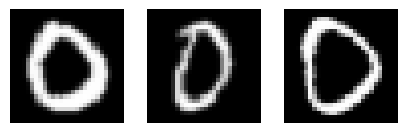

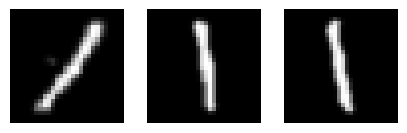

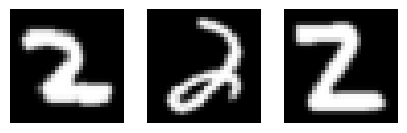

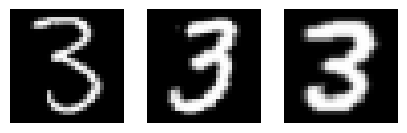

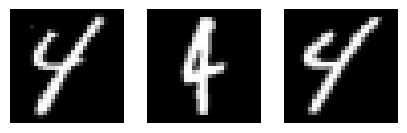

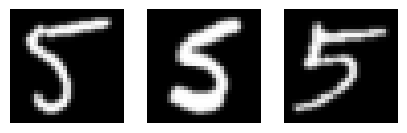

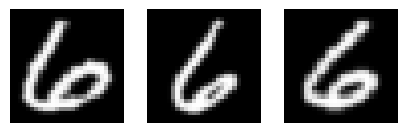

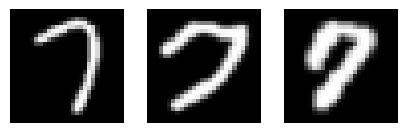

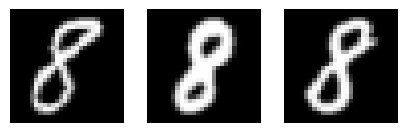

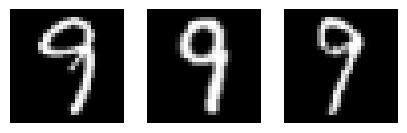

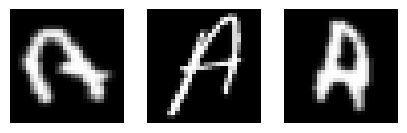

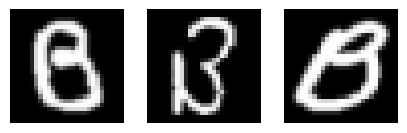

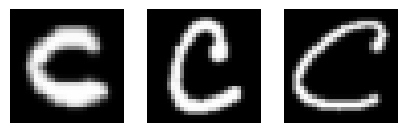

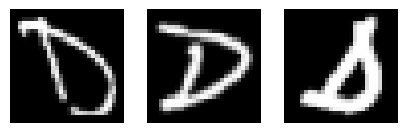

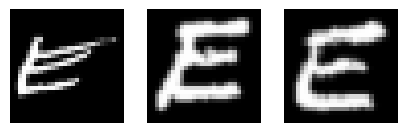

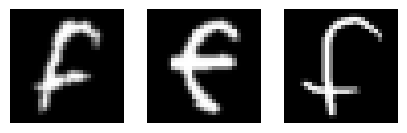

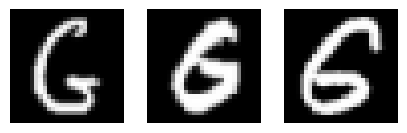

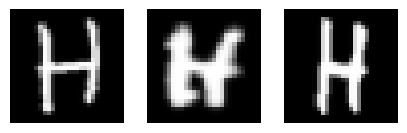

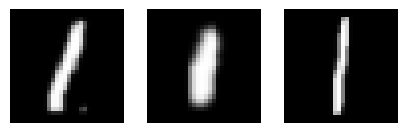

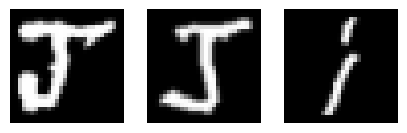

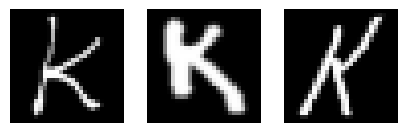

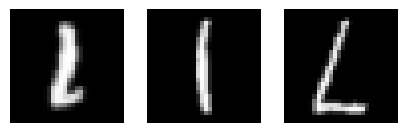

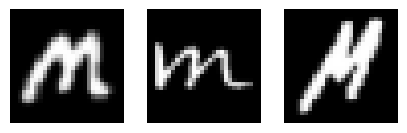

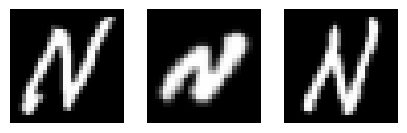

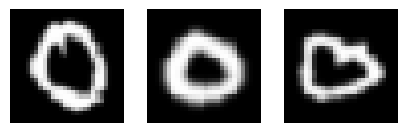

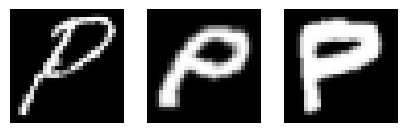

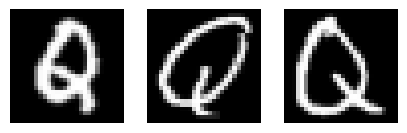

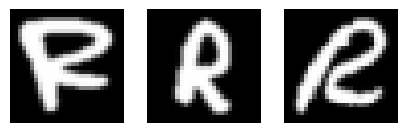

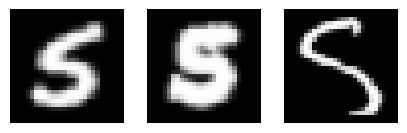

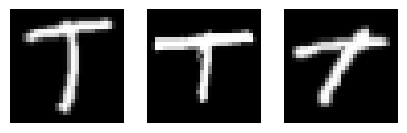

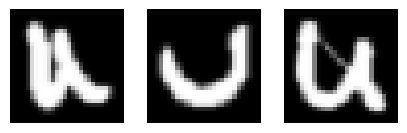

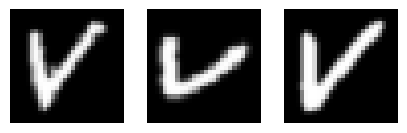

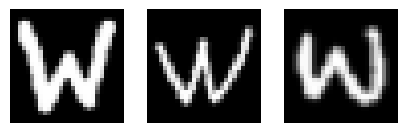

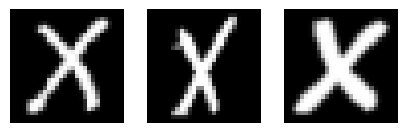

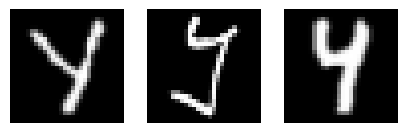

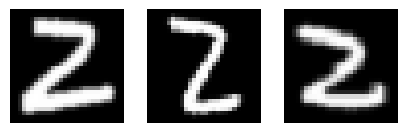

In [468]:
import numpy as np
import random

def show_samples_per_class(dataset, num_classes, samples_per_class=3):
    class_indices = [[] for _ in range(num_classes)]
    
    # Organize indices by class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    # Plot samples for each class
    for cls in range(num_classes):
        plt.figure(figsize=(5, 5))
        for i in range(samples_per_class):
            plt.subplot(1, samples_per_class, i + 1)
            idx = random.choice(class_indices[cls])
            image, label = dataset[idx]
            plt.imshow(image.squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()

# Show samples
show_samples_per_class(emnist_dataset, num_classes=num_classes)


['cnn_dataset/I/78398.png', 'cnn_dataset/0/17298.png', 'cnn_dataset/2/66235.png', 'cnn_dataset/C/103838.png']


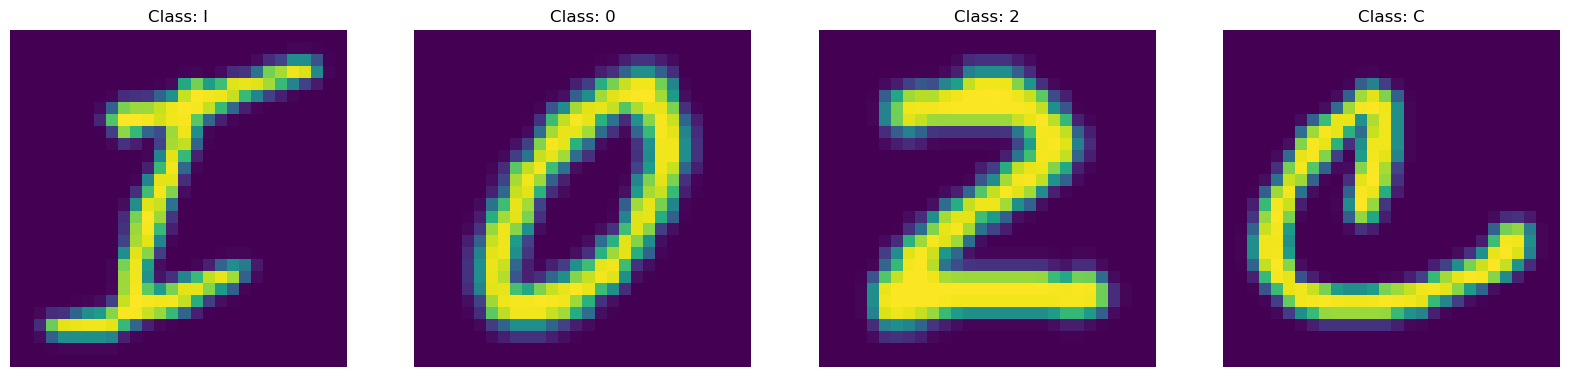

In [469]:

few_img = []
class_name = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
num = 4
random_class = random.sample(class_name, num)
for i in random_class:
    class_path = os.path.join(data_dir, i)
    class_images = [img for img in os.listdir(class_path) if img.endswith('.png')]
    if class_images:
        rand_image = random.choice(class_images)
        few_img.append(os.path.join(class_path, rand_image))
       
plt.figure(figsize=(20, 10))
print(few_img)
for i, img_path in enumerate(few_img):
    img = mpimg.imread(img_path)
    plt.subplot(1, num, i+1)
    plt.imshow(img)
    plt.title(f"Class: {os.path.basename(os.path.dirname(img_path))}")
    plt.axis('off')
plt.show()


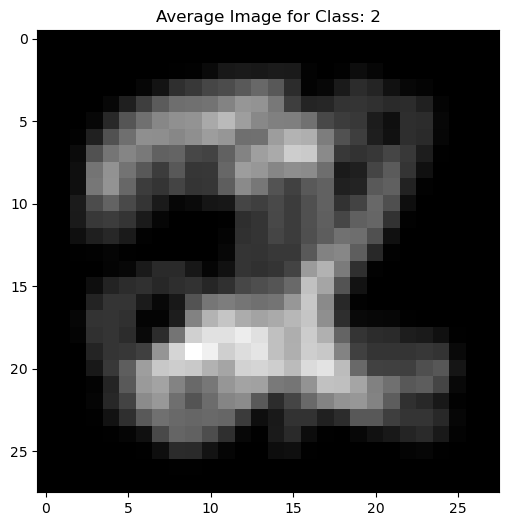

In [470]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

rand_class = random.choice(class_name)
class_path = os.path.join(data_dir, rand_class)
class_img = [img for img in os.listdir(class_path) if img.endswith('.png')]

num = 5
images_rand = random.sample(class_img, num)

def image(image_path):
    with Image.open(image_path) as img:
        return np.array(img)
np_array = np.array([image(os.path.join(class_path, img_name)) for img_name in images_rand])
ave = np.mean(np_array, axis=0)
plt.figure(figsize=(6, 6))
plt.imshow(ave, cmap='gray')
plt.title(f'Average Image for Class: {rand_class}')
plt.show()


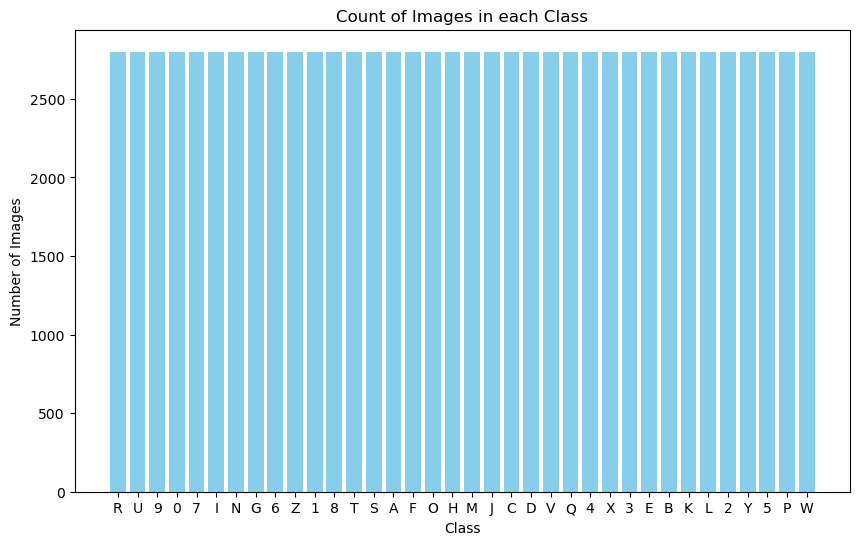

In [471]:
import os
import matplotlib.pyplot as plt

lis = os.listdir(data_dir)
dicti = {}
for i in lis:
    path_class = os.path.join(data_dir, i)
    if os.path.isdir(path_class):
        num_images = len(os.listdir(path_class))
        dicti[i] = num_images

plt.figure(figsize=(10, 6))
plt.bar(dicti.keys(), dicti.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Count of Images in each Class')
plt.show()


In [472]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.fclayers = nn.Sequential(
            nn.Linear(32 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 36)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        return x
    
    def summary(self):
        return summary(model)
    

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = SimpleCNN()
model.to(device)

mps


SimpleCNN(
  (convlayers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (fclayers): Sequential(
    (0): Linear(in_features=25088, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=36, bias=True)
  )
)

In [473]:
model.summary()

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       4,640
│    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-5                       3,211,392
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       4,644
Total params: 3,220,836
Trainable params: 3,220,836
Non-trainable params: 0

In [474]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [475]:
def trainevaltest_loop(train_loader, val_loader, test_loader, model, loss_fn, optimizer, num_epochs=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    size = len(train_loader.dataset)
    start_time = time.time()
    for epoch in range(num_epochs):
        print(f'------Epoch {epoch+1}------')
        model.train()
        total_train_loss = 0.0
        all_predicted_labels_train = []
        all_true_labels_train = []
        for batch, (X, y) in enumerate(train_loader):
            X,y = X.to(device), y.to(device)
            # Computing prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            total_train_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            all_predicted_labels_train.extend(predicted.cpu().numpy())
            all_true_labels_train.extend(y.cpu().numpy())

            # Back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"Train loss for each batch: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        accuracy_train = Accuracy(task="multiclass", num_classes=36)
        predicted_tensor = torch.tensor(all_predicted_labels_train)
        true_tensor = torch.tensor(all_true_labels_train)
        accuracy_train = accuracy_train(predicted_tensor, true_tensor)
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(accuracy_train)
        print(f"\nTrain Accuracy for epoch {epoch+1}/{num_epochs}: {accuracy_train*100:.2f}%")


        # Validation
        model.eval()
        total_loss_val = 0.0
        all_predicted_labels_val = []
        all_true_labels_val =[]
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = loss_fn(output, target)
                total_loss_val += val_loss.item()
                _, predicted = torch.max(output, 1)
                all_predicted_labels_val.extend(predicted.cpu().numpy())
                all_true_labels_val.extend(target.cpu().numpy())

        accuracy2 = Accuracy(task="multiclass", num_classes=36)
        predicted_tensor = torch.tensor(all_predicted_labels_val)
        true_tensor = torch.tensor(all_true_labels_val)
        accuracy_val = accuracy2(predicted_tensor, true_tensor)
        val_losses.append(total_loss_val / len(val_loader))
        val_accuracies.append(accuracy_val)
        print(f"Validation Accuracy after training the model: {accuracy_val*100:.2f}%")

    end_time = time.time()
    print(f'Time to train model: {end_time - start_time:.2f} seconds')
    
    # Testing
    model.eval()
    total_loss_test = 0.0
    test_predicted = []
    true_test =[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = loss_fn(outputs, labels)
            total_loss_test += test_loss.item()
            
            _, predicted = torch.max(outputs, 1)

            test_predicted.extend(predicted.cpu().numpy())
            true_test.extend(labels.cpu().numpy())

    accuracytest = Accuracy(task="multiclass", num_classes=36)
    predicted_tensor = torch.tensor(test_predicted)
    true_tensor = torch.tensor(true_test)
    accuracy_test = accuracytest(predicted_tensor, true_tensor)
    print(f'Test Accuracy after training and validation: {accuracy_test*100:.2f}')
    test_average_loss = total_loss_test / len(test_loader)
    print(f'Average Test Loss after training and validation: {test_average_loss:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(true_test, test_predicted, average='macro')
    print(f'Recall: {recall:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, accuracy_test, precision, recall, f1, test_predicted, true_test, test_average_loss

In [476]:
num_epochs = 3
train_losses, val_losses, train_accuracies, val_accuracies, accuracy_test, precision, recall, f1, test_predicted, true_test, test_loss = trainevaltest_loop(train_loader,val_loader, test_loader, model, criterion, optimizer, num_epochs)

------Epoch 1------
Train loss for each batch: 3.579963  [   64/80640]
Train loss for each batch: 1.394517  [ 6464/80640]
Train loss for each batch: 0.798283  [12864/80640]
Train loss for each batch: 0.532322  [19264/80640]
Train loss for each batch: 0.521997  [25664/80640]
Train loss for each batch: 0.718536  [32064/80640]
Train loss for each batch: 0.451835  [38464/80640]
Train loss for each batch: 0.566115  [44864/80640]
Train loss for each batch: 0.393765  [51264/80640]
Train loss for each batch: 0.241949  [57664/80640]
Train loss for each batch: 0.310327  [64064/80640]
Train loss for each batch: 0.577650  [70464/80640]
Train loss for each batch: 0.509944  [76864/80640]

Train Accuracy for epoch 1/3: 79.60%
Validation Accuracy after training the model: 86.58%
------Epoch 2------
Train loss for each batch: 0.615972  [   64/80640]
Train loss for each batch: 0.213368  [ 6464/80640]
Train loss for each batch: 0.393808  [12864/80640]
Train loss for each batch: 0.577524  [19264/80640]
Tr

In [477]:
def print_confusion_matrix(true_test, test_predicted):
    matrix = confusion_matrix(true_test, test_predicted)
    plt.figure(figsize=(16,14))
    sns.heatmap(matrix, annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def print_accuracy_plot(train_accuracies, val_accuracies, accuracy_test, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
    plt.axhline(y=accuracy_test, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('No of Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracies for Train, Test and Validation')
    plt.legend()
    plt.show()

def print_losses_plot(train_losses, val_losses, test_loss, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('No of Epochs')
    plt.ylabel('Losses')
    plt.title('Plot: Train, Test and Validation Losses')
    plt.legend()
    plt.show()

def printROC(test_loader, model):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            all_labels.append(labels)
            all_preds.append(probabilities)

    # Flatten the lists
    all_labels = np.concatenate([label.cpu().numpy() for label in all_labels])
    all_preds = np.concatenate([pred.cpu().numpy() for pred in all_preds])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = all_preds.shape[1]  # Number of classes

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()


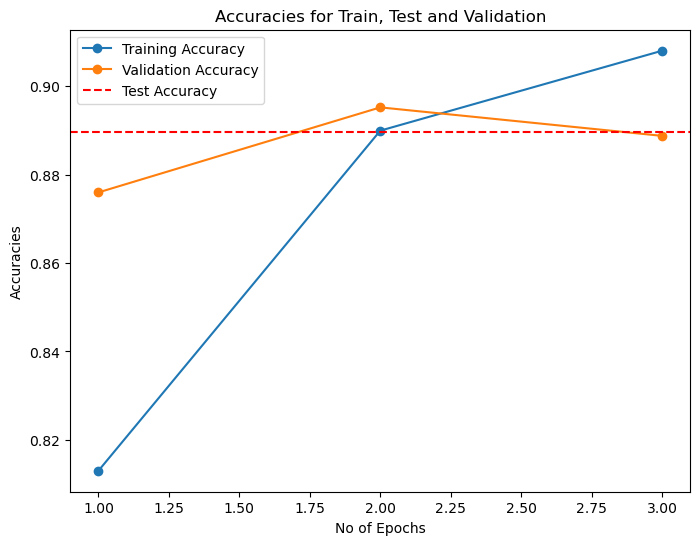

In [ ]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy_test, num_epochs)

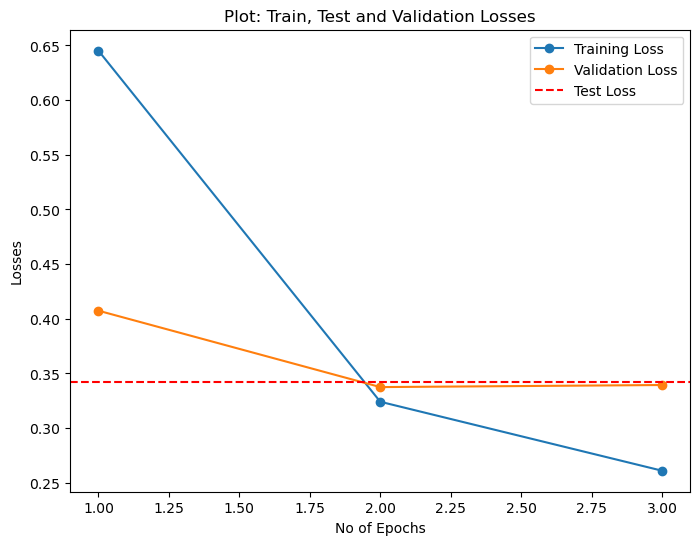

In [479]:
print_losses_plot(train_losses, val_losses, test_loss, num_epochs)

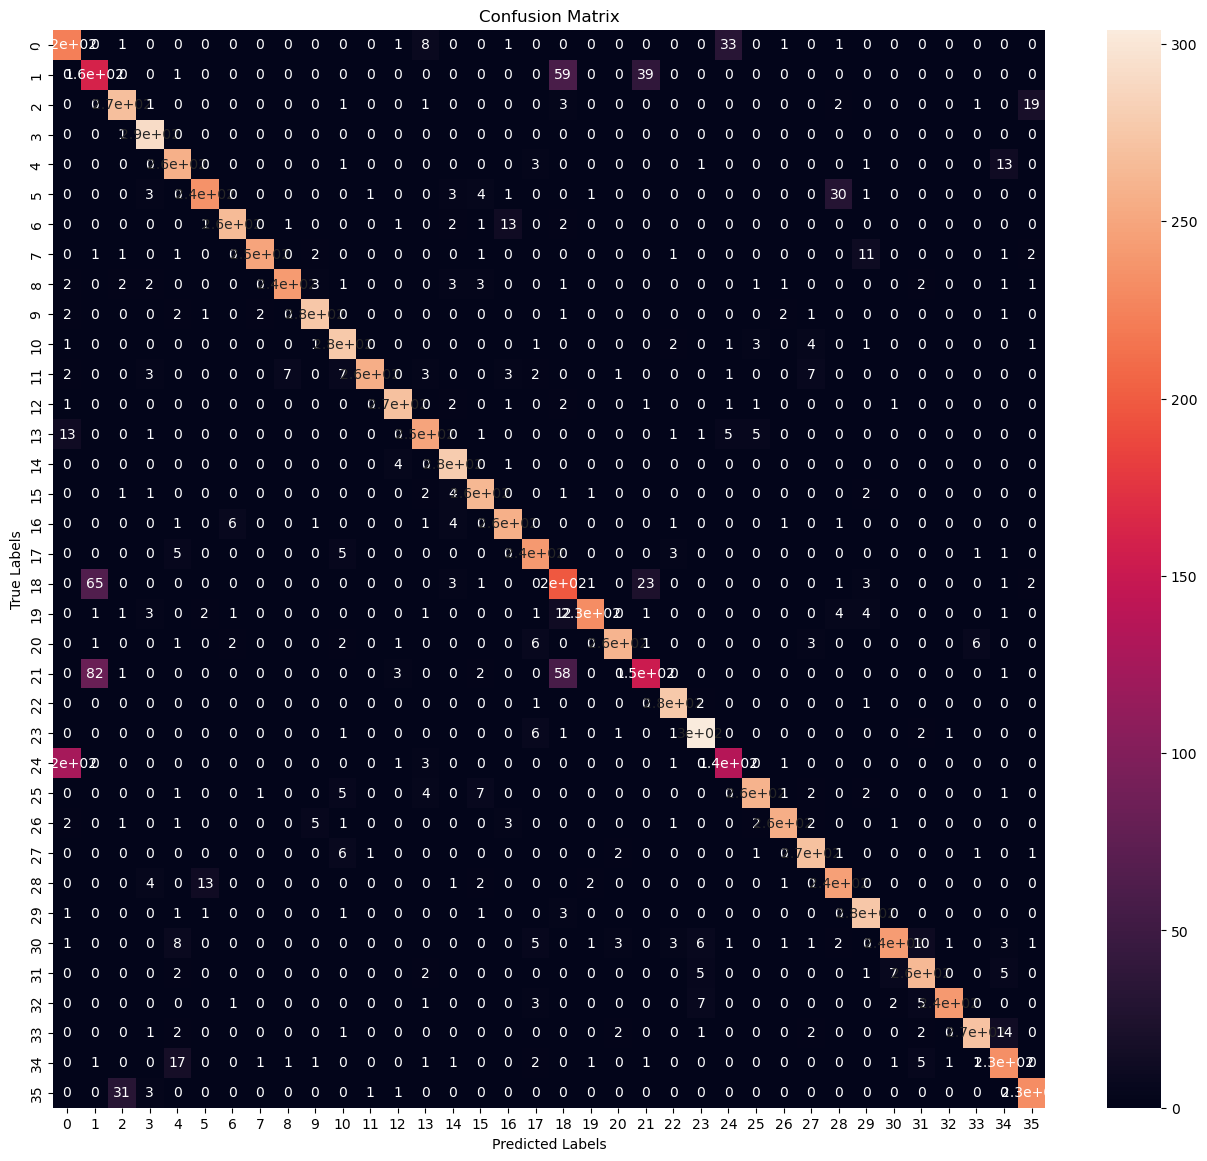

In [480]:
print_confusion_matrix(true_test, test_predicted)

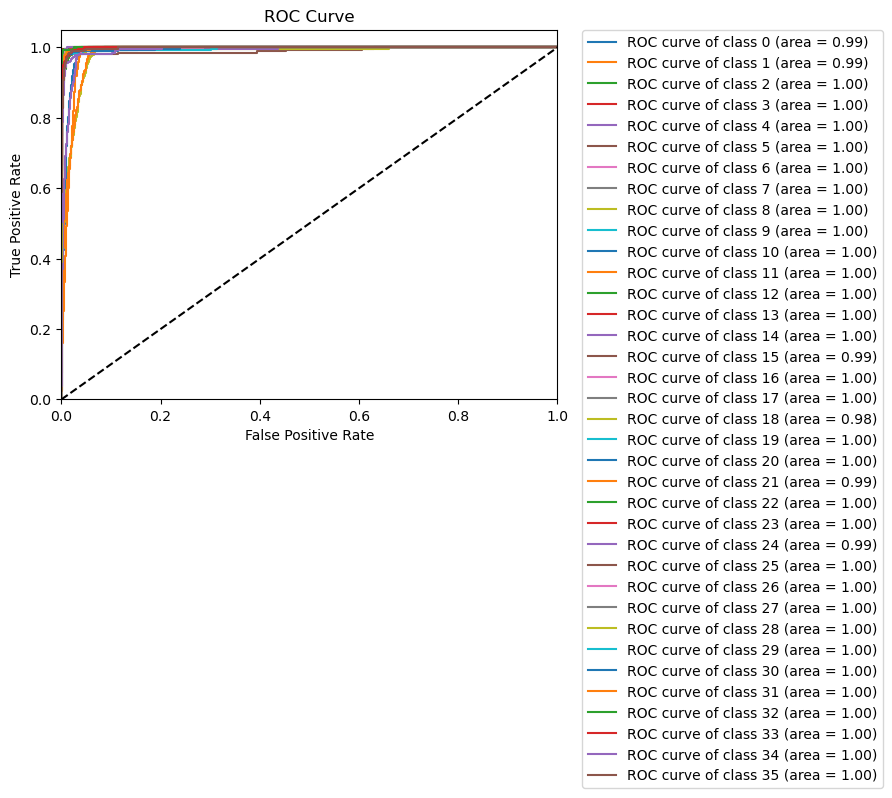

In [481]:
printROC(test_loader, model)

Early Stopping

In [482]:
best_val_accuracy = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
size = len(train_loader.dataset)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
for epoch in range(num_epochs):
    print(f'------Epoch {epoch+1}------')
    model.train()
    total_train_loss = 0.0
    all_predicted_labels_train = []
    all_true_labels_train = []
    for batch, (X, y) in enumerate(train_loader):
        X,y = X.to(device), y.to(device)
        # Computing prediction and loss
        pred = model(X)
        loss = criterion(pred, y)
        total_train_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        all_predicted_labels_train.extend(predicted.cpu().numpy())
        all_true_labels_train.extend(y.cpu().numpy())

        # Back propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Training loss for batch: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    accuracy_train = Accuracy(task="multiclass", num_classes=36)
    predicted_tensor = torch.tensor(all_predicted_labels_train)
    true_tensor = torch.tensor(all_true_labels_train)
    accuracy_train = accuracy_train(predicted_tensor, true_tensor)
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(accuracy_train)
    print(f"Train Accuracy for epoch {epoch+1}/{num_epochs}: {accuracy_train:.2f}%")


    # Validation
    model.eval()
    total_loss_val = 0.0
    all_predicted_labels_val = []
    all_true_labels_val =[]
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss = criterion(output, target)
            total_loss_val += val_loss.item()
            _, predicted = torch.max(output, 1)
            all_predicted_labels_val.extend(predicted.cpu().numpy())
            all_true_labels_val.extend(target.cpu().numpy())

    accuracy2 = Accuracy(task="multiclass", num_classes=36)
    predicted_tensor = torch.tensor(all_predicted_labels_val)
    true_tensor = torch.tensor(all_true_labels_val)
    accuracy_val = accuracy2(predicted_tensor, true_tensor)
    val_losses.append(total_loss_val / len(val_loader))
    val_accuracies.append(accuracy_val)
    print(f"Validation Accuracy for early stopping: {accuracy_val*100:.2f}%")

    if accuracy_val > best_val_accuracy:
        best_val_accuracy = accuracy_val 
        torch.save(model.state_dict(), 'best_early_model.pth')

end_time = time.time()
print(f'\nTime to train model: {end_time - start_time:.2f} seconds')

best_early_model = SimpleCNN()
best_early_model.load_state_dict(torch.load('best_early_model.pth'))
best_early_model.to(device)

best_early_model.eval()
total_correct_test = 0
total_samples_test = 0
total_loss_test = 0.0
test_predicted = []
true_test =[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_early_model(inputs)
        test_loss = criterion(outputs, labels)
        total_loss_test += test_loss.item()
        _, predicted = torch.max(outputs, 1)
        test_predicted.extend(predicted.cpu().numpy())
        true_test.extend(labels.cpu().numpy())

accuracytest = Accuracy(task="multiclass", num_classes=36)
predicted_tensor = torch.tensor(test_predicted)
true_tensor = torch.tensor(true_test)
accuracy_test = accuracytest(predicted_tensor, true_tensor)
print(f'Test Accuracy for Early stopping: {accuracy_test*100:.2f}')
test_average_loss = total_loss_test / len(test_loader)
print(f'Average Loss: {test_average_loss:.4f}')

precision, recall, f1, _ = precision_recall_fscore_support(true_test, test_predicted, average='macro')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')

------Epoch 1------
Training loss for batch: 0.231489  [   64/80640]
Training loss for batch: 0.257176  [ 6464/80640]
Training loss for batch: 0.226133  [12864/80640]
Training loss for batch: 0.132544  [19264/80640]
Training loss for batch: 0.148290  [25664/80640]
Training loss for batch: 0.245262  [32064/80640]
Training loss for batch: 0.195212  [38464/80640]
Training loss for batch: 0.328090  [44864/80640]
Training loss for batch: 0.149031  [51264/80640]
Training loss for batch: 0.241939  [57664/80640]
Training loss for batch: 0.237743  [64064/80640]
Training loss for batch: 0.250424  [70464/80640]
Training loss for batch: 0.457325  [76864/80640]
Train Accuracy for epoch 1/3: 0.91%
Validation Accuracy for early stopping: 88.58%
------Epoch 2------
Training loss for batch: 0.309824  [   64/80640]
Training loss for batch: 0.195556  [ 6464/80640]
Training loss for batch: 0.057699  [12864/80640]
Training loss for batch: 0.097374  [19264/80640]
Training loss for batch: 0.121560  [25664/80

L2 Regularization

In [483]:
regularization_model = SimpleCNN()
optimizer = optim.Adam(regularization_model.parameters(), lr=0.001, weight_decay=0.000001)
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, train_accuracies, val_accuracies, accuracy_test, precision, recall, f1, test_predicted, true_test, test_loss = trainevaltest_loop(train_loader,val_loader, test_loader, model, criterion, optimizer)

------Epoch 1------
Train loss for each batch: 0.166575  [   64/80640]
Train loss for each batch: 0.058911  [ 6464/80640]
Train loss for each batch: 0.145313  [12864/80640]
Train loss for each batch: 0.170819  [19264/80640]
Train loss for each batch: 0.107367  [25664/80640]
Train loss for each batch: 0.156233  [32064/80640]
Train loss for each batch: 0.076089  [38464/80640]
Train loss for each batch: 0.237890  [44864/80640]
Train loss for each batch: 0.169455  [51264/80640]
Train loss for each batch: 0.150245  [57664/80640]
Train loss for each batch: 0.149491  [64064/80640]
Train loss for each batch: 0.055368  [70464/80640]
Train loss for each batch: 0.127156  [76864/80640]

Train Accuracy for epoch 1/3: 94.41%
Validation Accuracy after training the model: 88.47%
------Epoch 2------
Train loss for each batch: 0.192567  [   64/80640]
Train loss for each batch: 0.138011  [ 6464/80640]
Train loss for each batch: 0.148627  [12864/80640]
Train loss for each batch: 0.260401  [19264/80640]
Tr

<h5>LR Scheduling</h5>

In [484]:
best_val_accuracy = 0
best_lr = 0
train_losses = []
val_losses = []
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_accuracies = []
learning_rates = []
val_accuracies = []

size = len(train_loader.dataset)
start_time = time.time()
for epoch in range(num_epochs):
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    print(f'-----------Epoch {epoch+1}, Learning Rate: {current_lr}------------')
    # print(f'------Epoch {epoch+1}------')
    model.train()
    total_train_loss = 0.0
    all_predicted_labels_train = []
    all_true_labels_train = []
    for batch, (X, y) in enumerate(train_loader):
        X,y = X.to(device), y.to(device)
        # Computing prediction and loss
        pred = model(X)
        loss = criterion(pred, y)
        total_train_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        all_predicted_labels_train.extend(predicted.cpu().numpy())
        all_true_labels_train.extend(y.cpu().numpy())

        # Back propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Training loss for batch: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    accuracy_train = Accuracy(task="multiclass", num_classes=36)
    predicted_tensor = torch.tensor(all_predicted_labels_train)
    true_tensor = torch.tensor(all_true_labels_train)
    accuracy_train = accuracy_train(predicted_tensor, true_tensor)
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(accuracy_train)
    print(f"Train Accuracy for epoch {epoch+1}/{num_epochs}: {accuracy_train:.2f}%")

    # Validation
    model.eval()
    total_loss_val = 0.0
    all_predicted_labels_val = []
    all_true_labels_val =[]
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss = criterion(output, target)
            total_loss_val += val_loss.item()
            _, predicted = torch.max(output, 1)
            all_predicted_labels_val.extend(predicted.cpu().numpy())
            all_true_labels_val.extend(target.cpu().numpy())

    accuracy2 = Accuracy(task="multiclass", num_classes=36)
    predicted_tensor = torch.tensor(all_predicted_labels_val)
    true_tensor = torch.tensor(all_true_labels_val)
    accuracy_val = accuracy2(predicted_tensor, true_tensor)
    val_losses.append(total_loss_val / len(val_loader))
    val_accuracies.append(accuracy_val)
    print(f"Validation Accuracy for LR scheduler: {accuracy_val*100:.2f}%")

    if accuracy_val > best_val_accuracy:
        best_lr = current_lr
        torch.save(model.state_dict(), 'best_lr_model.pth')

end_time = time.time()
print(f'Time to train model: {end_time - start_time:.2f} seconds')

best_lr_model = SimpleCNN()
best_lr_model.load_state_dict(torch.load('best_lr_model.pth'))
best_lr_model.to(device)
best_lr_model.eval()
total_correct_test = 0
total_samples_test = 0
total_loss_test = 0.0
test_predicted = []
true_test =[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_lr_model(inputs)
        test_loss = criterion(outputs, labels)
        total_loss_test += test_loss.item()
        
        _, predicted = torch.max(outputs, 1)
        test_predicted.extend(predicted.cpu().numpy())
        true_test.extend(labels.cpu().numpy())
accuracytest = Accuracy(task="multiclass", num_classes=36)
predicted_tensor = torch.tensor(test_predicted)
true_tensor = torch.tensor(true_test)
accuracy_test = accuracytest(predicted_tensor, true_tensor)
print(f'Test Accuracy for LR Scheduler: {accuracy_test*100:.2f}')
average_loss = total_loss_test / len(test_loader)
print(f'Average Test Loss after training and validation: {average_loss:.4f}')
precision, recall, f1, _ = precision_recall_fscore_support(true_test, test_predicted, average='macro')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')

-----------Epoch 1, Learning Rate: 0.001------------


/Users/charankumarnara/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training loss for batch: 0.076140  [   64/80640]
Training loss for batch: 0.044274  [ 6464/80640]
Training loss for batch: 0.106899  [12864/80640]
Training loss for batch: 0.176703  [19264/80640]
Training loss for batch: 0.173779  [25664/80640]
Training loss for batch: 0.133781  [32064/80640]
Training loss for batch: 0.216422  [38464/80640]
Training loss for batch: 0.088921  [44864/80640]
Training loss for batch: 0.079393  [51264/80640]
Training loss for batch: 0.162007  [57664/80640]
Training loss for batch: 0.192579  [64064/80640]
Training loss for batch: 0.086260  [70464/80640]
Training loss for batch: 0.079093  [76864/80640]
Train Accuracy for epoch 1/3: 0.94%
Validation Accuracy for LR scheduler: 88.47%
-----------Epoch 2, Learning Rate: 0.001------------
Training loss for batch: 0.056820  [   64/80640]
Training loss for batch: 0.127557  [ 6464/80640]
Training loss for batch: 0.113343  [12864/80640]
Training loss for batch: 0.147898  [19264/80640]
Training loss for batch: 0.222591

In [485]:
class BatchNN(nn.Module):
    def __init__(self):
        super(BatchNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 28 * 28, 128) 
        self.batch = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 36)  # 36 output classes (0-9 and A-Z)
    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu3(self.batch(self.fc1(x)))
        x = self.fc2(x)
        return x
    
    def summary(self):
        return summary(model)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = BatchNN()
model.to(device)

mps


BatchNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)

In [486]:
best_batch_model = BatchNN()
best_batch_model.to(device)
optimizer = optim.Adam(best_batch_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print()
print(f"Training with Batch Normalization")
train_losses, val_losses, train_accuracies, val_accuracies, accuracy_test, precision, recall, f1, test_predicted, true_test, test_loss = trainevaltest_loop(train_loader,val_loader, test_loader, best_batch_model, criterion, optimizer)


Training with Batch Normalization
------Epoch 1------
Train loss for each batch: 3.663938  [   64/80640]
Train loss for each batch: 0.949000  [ 6464/80640]
Train loss for each batch: 0.602172  [12864/80640]
Train loss for each batch: 0.597705  [19264/80640]
Train loss for each batch: 0.394795  [25664/80640]
Train loss for each batch: 0.346499  [32064/80640]
Train loss for each batch: 0.353613  [38464/80640]
Train loss for each batch: 0.243874  [44864/80640]
Train loss for each batch: 0.288364  [51264/80640]
Train loss for each batch: 0.427825  [57664/80640]
Train loss for each batch: 0.218450  [64064/80640]
Train loss for each batch: 0.453088  [70464/80640]
Train loss for each batch: 0.295464  [76864/80640]

Train Accuracy for epoch 1/3: 84.69%
Validation Accuracy after training the model: 88.76%
------Epoch 2------
Train loss for each batch: 0.224851  [   64/80640]
Train loss for each batch: 0.226490  [ 6464/80640]
Train loss for each batch: 0.215417  [12864/80640]
Train loss for eac

<h5>Saving the best model</h5>

In [487]:

torch.save(best_batch_model.state_dict(), 'cnara_dharmaac_assignment2_part3.h5')

<h5>Training and plotting metrics graphs for Best batch model</h5>

In [488]:
best_batch_model.to(device)
optimizer = optim.Adam(best_batch_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, train_accuracies, val_accuracies, accuracy_test, precision, recall, f1, test_predicted, true_test, test_loss = trainevaltest_loop(train_loader,val_loader, test_loader, best_batch_model, criterion, optimizer)

------Epoch 1------
Train loss for each batch: 0.163180  [   64/80640]
Train loss for each batch: 0.157769  [ 6464/80640]
Train loss for each batch: 0.161641  [12864/80640]
Train loss for each batch: 0.091830  [19264/80640]
Train loss for each batch: 0.216367  [25664/80640]
Train loss for each batch: 0.150074  [32064/80640]
Train loss for each batch: 0.178342  [38464/80640]
Train loss for each batch: 0.169544  [44864/80640]
Train loss for each batch: 0.191448  [51264/80640]
Train loss for each batch: 0.153789  [57664/80640]
Train loss for each batch: 0.255446  [64064/80640]
Train loss for each batch: 0.155225  [70464/80640]
Train loss for each batch: 0.095281  [76864/80640]

Train Accuracy for epoch 1/3: 93.57%
Validation Accuracy after training the model: 88.96%
------Epoch 2------
Train loss for each batch: 0.052070  [   64/80640]
Train loss for each batch: 0.194158  [ 6464/80640]
Train loss for each batch: 0.069825  [12864/80640]
Train loss for each batch: 0.036902  [19264/80640]
Tr

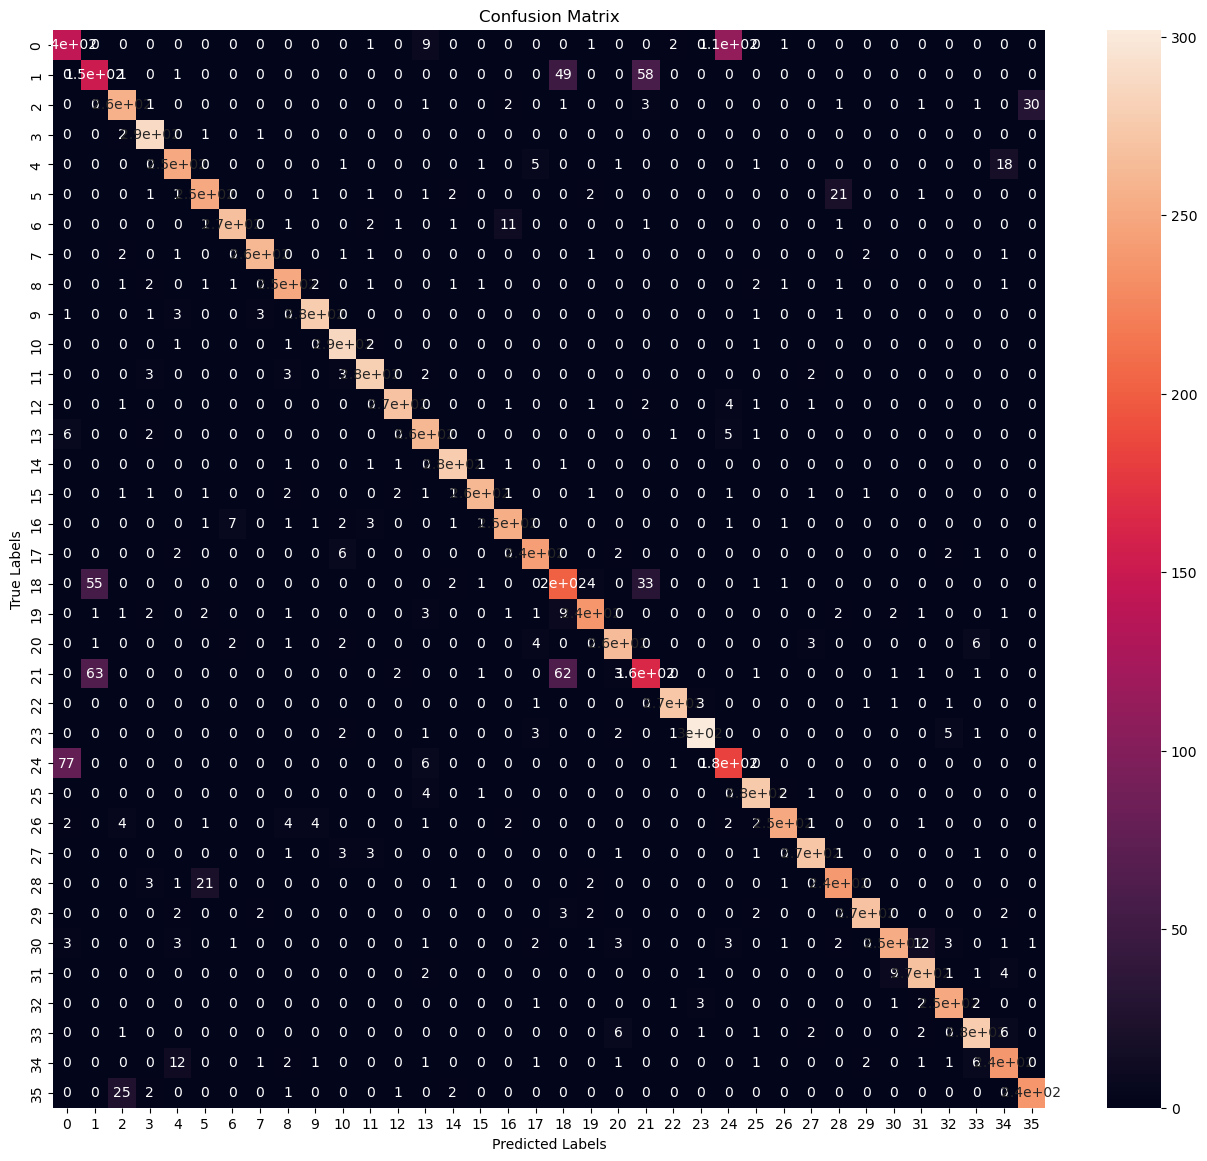

In [489]:
print_confusion_matrix(true_test, test_predicted)

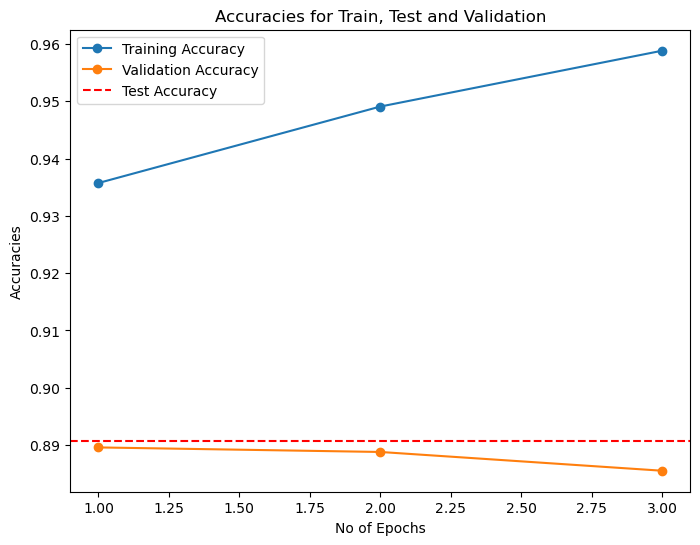

In [490]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy_test, num_epochs)

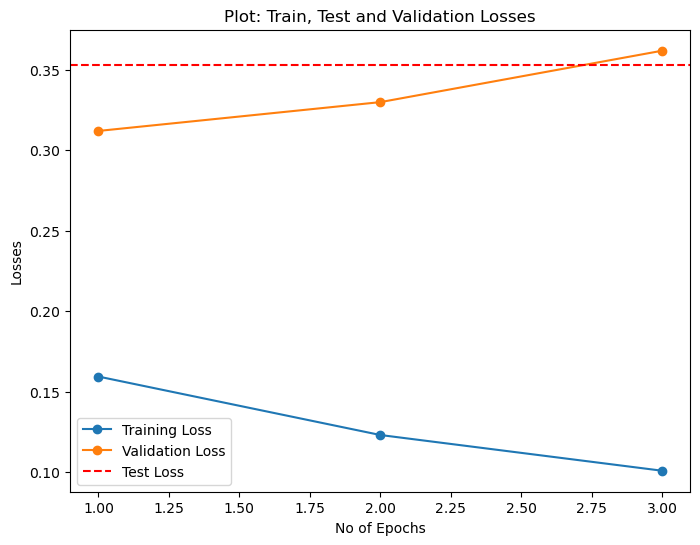

In [491]:
print_losses_plot(train_losses, val_losses, test_loss, num_epochs)

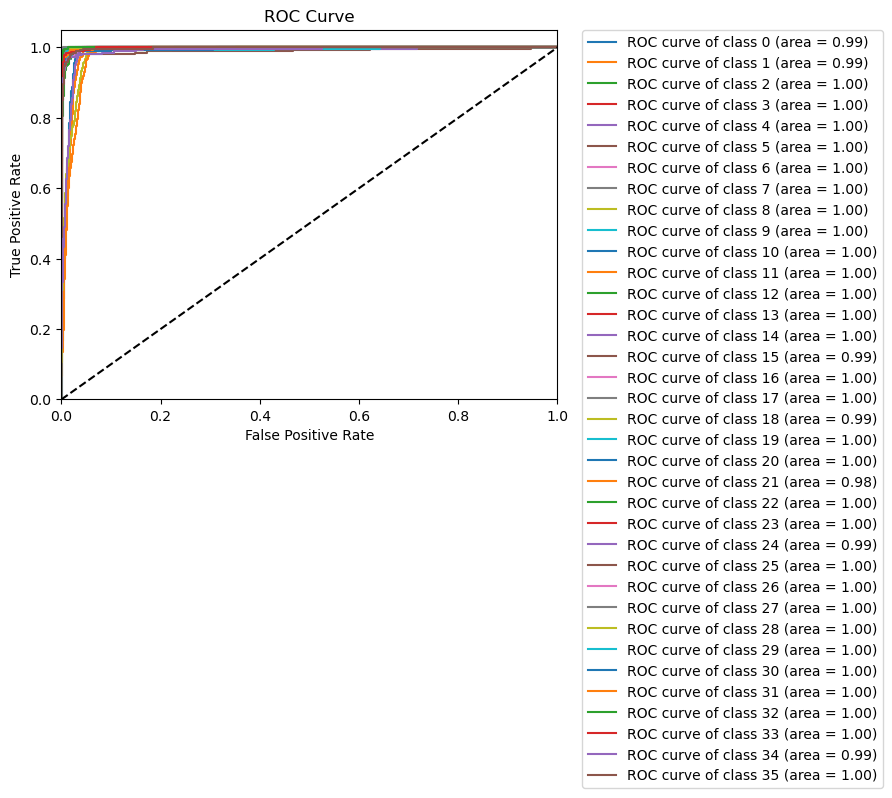

In [492]:
printROC(test_loader, best_batch_model)

<h2> VGG Network </h2>

In [493]:
class VGG11Network(nn.Module):
    def __init__(self, num_classes=36): 
        super(VGG11Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    def summary(self):
        return summary(vgg)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
vgg = VGG11Network()
vgg.to(device)

mps


VGG11Network(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [494]:
vgg.summary()

Layer (type:depth-idx)                   Param #
VGG11Network                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       73,856
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       295,168
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       590,080
│    └─ReLU: 2-10                        --
│    └─MaxPool2d: 2-11                   --
│    └─Conv2d: 2-12                      1,180,160
│    └─ReLU: 2-13                        --
│    └─Conv2d: 2-14                      2,359,808
│    └─ReLU: 2-15                        --
│    └─MaxPool2d: 2-16                   --
│    └─Conv2d: 2-17                      2,359,808
│    └─ReLU: 2-18                        --
│    └─Conv2d: 2-19                

In [495]:
optimizer = optim.Adam(vgg.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [496]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.Grayscale(), 
    transforms.ToTensor(),   
    transforms.Normalize(mean=[0.5], std=[0.5])  
])
emnist_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(emnist_dataset))
val_size = int(0.1 * len(emnist_dataset))
test_size = len(emnist_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    emnist_dataset, [train_size, val_size, test_size]
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(emnist_dataset.classes)
print(f"Number of classes: {num_classes}")



Number of classes: 36


In [497]:
def trainevaltest_loop(train_loader, val_loader, test_loader, model, loss_fn, optimizer, num_epochs=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    size = len(train_loader.dataset)
    start_time = time.time()
    for epoch in range(num_epochs):
        print(f'------Epoch {epoch+1}------')
        model.train()
        total_train_loss = 0.0
        all_predicted_labels_train = []
        all_true_labels_train = []
        for batch, (X, y) in enumerate(train_loader):
            X,y = X.to(device), y.to(device)
            # Computing prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            total_train_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            all_predicted_labels_train.extend(predicted.cpu().numpy())
            all_true_labels_train.extend(y.cpu().numpy())

            # Back propagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"Train loss for batch: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        accuracy_train = Accuracy(task="multiclass", num_classes=36)
        predicted_tensor = torch.tensor(all_predicted_labels_train)
        true_tensor = torch.tensor(all_true_labels_train)
        accuracy_train = accuracy_train(predicted_tensor, true_tensor)
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(accuracy_train)
        print(f"\nTrain Accuracy for epoch {epoch+1}/{num_epochs}: {accuracy_train:.2f}%")


        # Validation
        model.eval()
        total_loss_val = 0.0
        all_predicted_labels_val = []
        all_true_labels_val =[]
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = loss_fn(output, target)
                total_loss_val += val_loss.item()
                _, predicted = torch.max(output, 1)
                all_predicted_labels_val.extend(predicted.cpu().numpy())
                all_true_labels_val.extend(target.cpu().numpy())

        accuracy2 = Accuracy(task="multiclass", num_classes=36)
        predicted_tensor = torch.tensor(all_predicted_labels_val)
        true_tensor = torch.tensor(all_true_labels_val)
        accuracy_val = accuracy2(predicted_tensor, true_tensor)
        val_losses.append(total_loss_val / len(val_loader))
        val_accuracies.append(accuracy_val)
        print(f"Validation Accuracy after training the model: {accuracy_val*100:.2f}%")

    end_time = time.time()
    print(f'Time to train model: {end_time - start_time:.2f} seconds')
    
    # Testing
    model.eval()
    total_loss_test = 0.0
    test_predicted = []
    true_test =[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = loss_fn(outputs, labels)
            total_loss_test += test_loss.item()
            
            _, predicted = torch.max(outputs, 1)

            test_predicted.extend(predicted.cpu().numpy())
            true_test.extend(labels.cpu().numpy())

    accuracytest = Accuracy(task="multiclass", num_classes=36)
    predicted_tensor = torch.tensor(test_predicted)
    true_tensor = torch.tensor(true_test)
    accuracy_test = accuracytest(predicted_tensor, true_tensor)
    print(f'Test Accuracy after training and validation: {accuracy_test*100:.2f}')

    test_average_loss = total_loss_test / len(test_loader)
    print(f'Average Test Loss after training and validation: {test_average_loss:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(true_test, test_predicted, average='macro')
    print(f'Recall: {recall:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, accuracy_test, precision, recall, f1, test_predicted, true_test, test_average_loss

In [498]:
train_losses, val_losses, train_accuracies, val_accuracies, accuracy_test, precision, recall, f1, test_predicted, true_test, test_loss = trainevaltest_loop(train_loader,val_loader, test_loader, vgg, criterion, optimizer)

------Epoch 1------
Train loss for batch: 3.586138  [   64/80640]
Train loss for batch: 3.583597  [ 6464/80640]
Train loss for batch: 3.266571  [12864/80640]
Train loss for batch: 2.762508  [19264/80640]
Train loss for batch: 1.998974  [25664/80640]
Train loss for batch: 1.857254  [32064/80640]
Train loss for batch: 1.297162  [38464/80640]
Train loss for batch: 0.909775  [44864/80640]
Train loss for batch: 0.840530  [51264/80640]
Train loss for batch: 0.957308  [57664/80640]
Train loss for batch: 0.607234  [64064/80640]
Train loss for batch: 0.501691  [70464/80640]
Train loss for batch: 0.620383  [76864/80640]

Train Accuracy for epoch 1/3: 0.47%
Validation Accuracy after training the model: 82.43%
------Epoch 2------
Train loss for batch: 0.600083  [   64/80640]
Train loss for batch: 0.475652  [ 6464/80640]
Train loss for batch: 0.600803  [12864/80640]
Train loss for batch: 0.360287  [19264/80640]
Train loss for batch: 0.666350  [25664/80640]
Train loss for batch: 0.560327  [32064/806

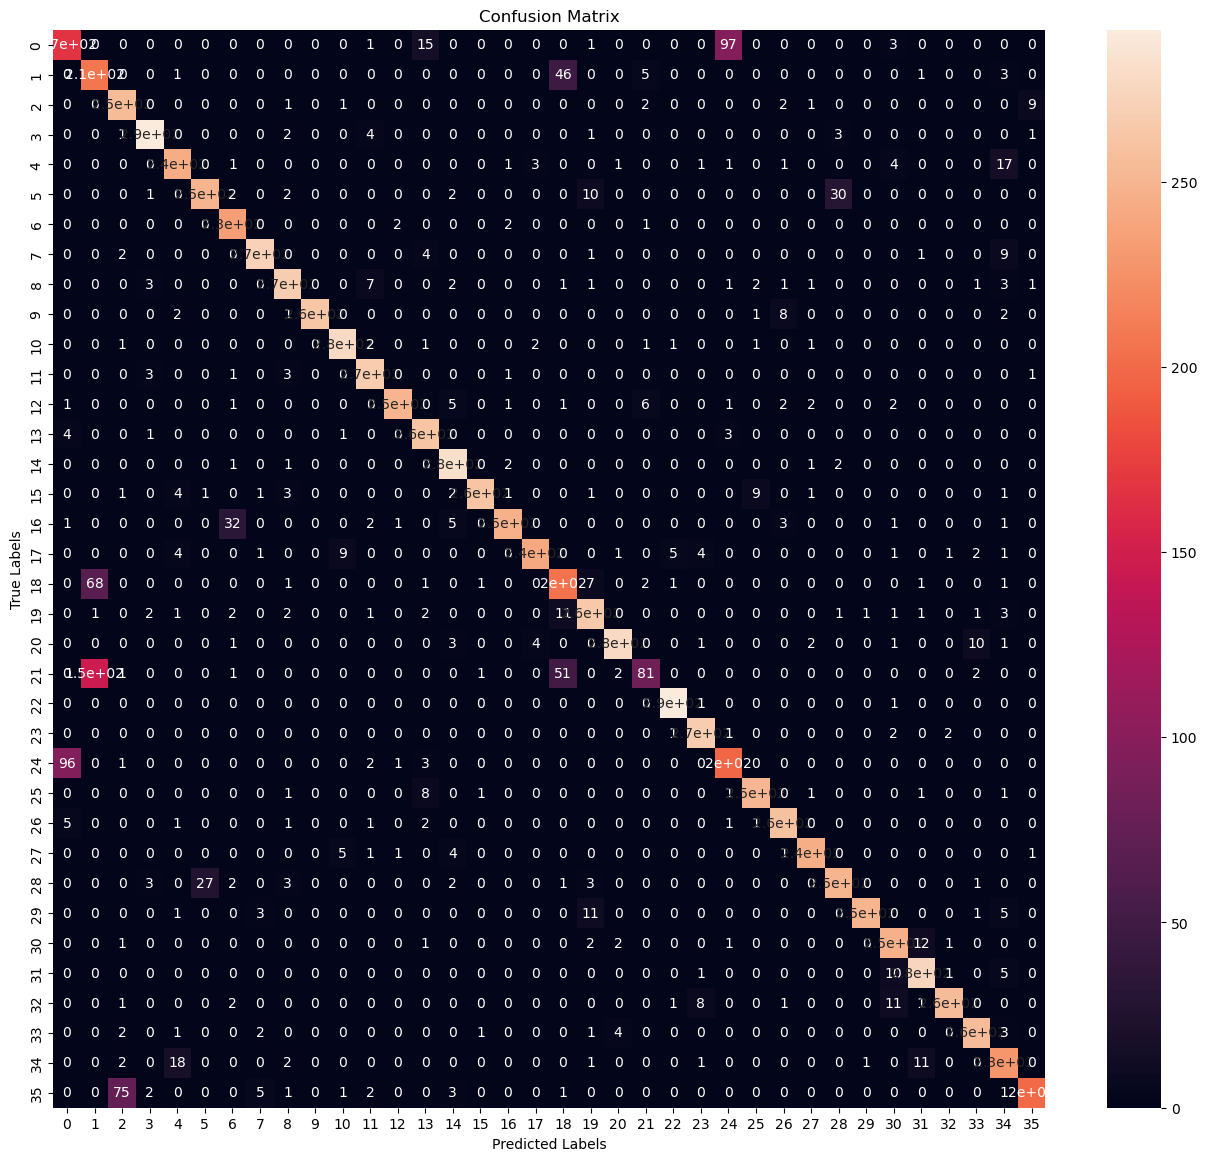

In [499]:
print_confusion_matrix(true_test, test_predicted)

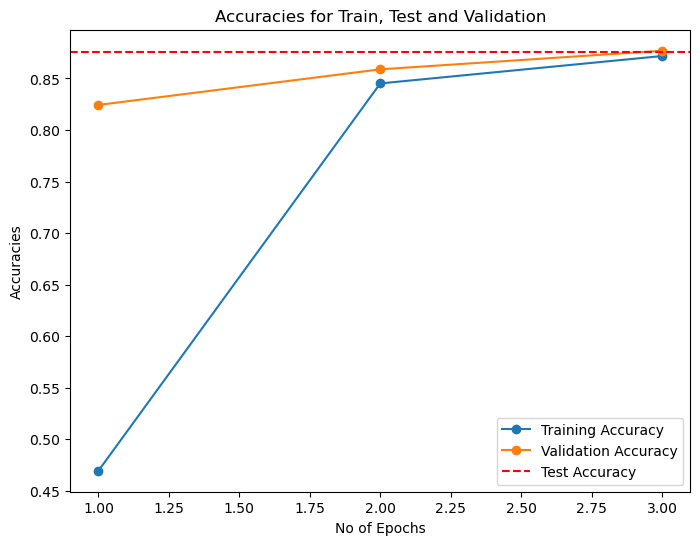

In [500]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy_test, num_epochs)

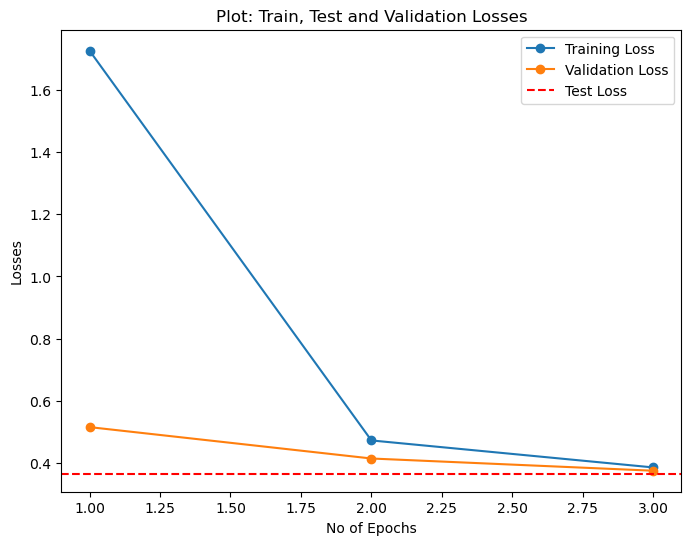

In [501]:
print_losses_plot(train_losses, val_losses, test_loss, num_epochs)

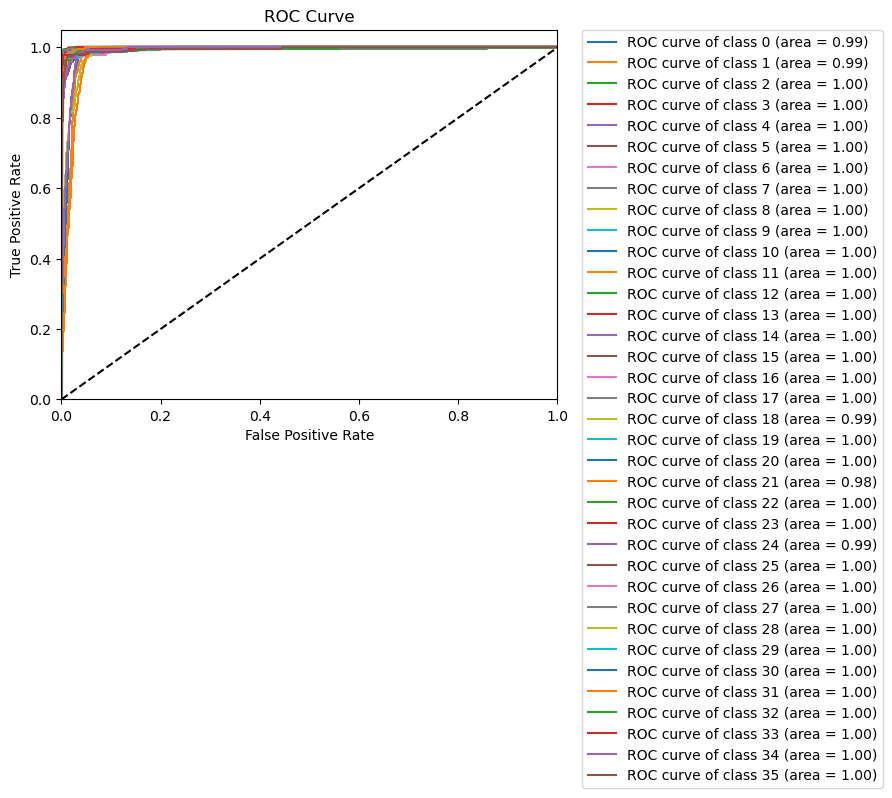

In [502]:
printROC(test_loader, vgg)

<h5>Saving the VGG model</h5>

In [503]:
torch.save(vgg.state_dict(), 'cnara_dharmaac_assignment2_part4.h5')

<h4>References</h4>
<p>https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html</p>
<p>https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</p>
<p>https://pytorch.org/vision/main/models/vgg.html</p>

<h4>Contribution</h4>
<b>Charan Kumar Nara: 50%</b><br>
<b>Dharma Acha: 50%</b>